# Polarization Measurement

This notebook demonstrates setting up integration time calculations in POL mode.


If running via Google Colab, you must first execute the contents of notebook `00_Google_Colab_Setup.ipynb` (only if you have never done so previously). Then execute all cells tagged with &#128992;.  If running via a local installation, you should skip all of the colab-specific (&#128992;) cells.

## 🟠 Setup for Google Colab Use

### 🟠 Run the next cell to mount the Google Drive

You will receive some or all of the following prompts:

* Warning: This notebook was not authored by Google - Click "Run Anyway"
* Permit this notebook to access your Google Drive files? - Click "Connect to Google Drive"
* A new browser window will prompt you to select an account and authorize access
  * Select the Google account you wish to use and click Continue on each subsequent screen until the dialog vanishes

Upon completion of cell execution, you should see `Mounted at /content/drive`

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### 🟠 Run the next cell to change to the corgietc directory and install the required software

This process should take less than a minute, but, depending on bandwidth availability, may take as long as a few minutes. You will see a variety of messages about package downloads.  Upon completion of cell execution, you should see `Sucessfully installed` followed by a list of installed packages and their versions.

You may see the prompt "Restart session".  You do not need to do this - click 'Cancel'.

In [ ]:
# This cell should *only* be executed if running the notebook in Google Colab
import os

# Google top level drive dir
drive_dir = "/content/drive/MyDrive/"

# directory path
corgietc_dir = 'corgietc'
corgietc_path = os.path.join(drive_dir, corgietc_dir)
cgi_noise_repo_path = os.path.join(corgietc_path, "cgi_noise")
corgietc_repo_path = os.path.join(corgietc_path, "corgietc")
corgietc_notebooks_path = os.path.join(corgietc_repo_path, "Notebooks")

# Change to the cgi_noise repo path and update the repo
os.chdir(cgi_noise_repo_path)
!git pull

# Install the backend and all requirements - this can also take a little while
!pip install .

# Change to the corgietc repo path and update the repo
os.chdir(corgietc_repo_path)
!git pull

# Install the backend and all requirements - this can also take a little while
!pip install .

# Refresh package list to pick up new installations
import site
site.main()

# Change to the Notebooks directory
os.chdir(corgietc_notebooks_path)

### 🟠 Import jupyter widget for Colab

In [ ]:
# need to import third party jupyter widget
from google.colab import output
output.enable_custom_widget_manager()

## All Cells from this point should be run for both Colab and local installations

In [1]:
# import all required packages
from corgietc.corgietc import corgietc
import os
import json
import yaml
from EXOSIMS.Prototypes.TargetList import TargetList
import EXOSIMS.Prototypes.TimeKeeping
import EXOSIMS.Observatory.ObservatoryL2Halo
import EXOSIMS.PlanetPhysicalModel.ForecasterMod
from EXOSIMS.util.deltaMag import deltaMag
from EXOSIMS.util.phaseFunctions import phi_lambert
from keplertools import fun as kepler_fun
import copy
import astropy.units as u
from astropy.time import Time
import numpy as np
import matplotlib.pyplot as plt

## Defining all other parameters, Constructing EXOSIMS Objects

All EXOSIMS objects are constructed via an input specification - a dictionary of key/value pairs, that can be read from a JSON-formatted file stored on disk. Passing such an input specification to a TargetList automatically creates the TargetList, along with all other EXOSIMS modules required by the TargetList, which includes the OpticalSystem and ZodiacalLight modules (the ones we need for doing our calculations). More info on EXOSIMS objects is available here: https://exosims.readthedocs.io/en/latest/intro.html#framework

corgietc provides a default input specification, which we will now load:

In [2]:
scriptfile = os.path.join(os.environ["CORGIETC_DATA_DIR"], "scripts", "CGI_Noise.json")
with open(scriptfile, "r") as f:
    specs = json.loads(f.read())

In order to deminstrate how contrast degradation works, we first need to define various input components for Cp_Cb_Csp and calc_intTime functions. Those are, Target List (TL), Optical System (OS), etc. See 01_Anatomy_of_an_Integration_Time_Calculation.ipynb Notebook for further details.

In [3]:
TL = EXOSIMS.Prototypes.TargetList.TargetList(**copy.deepcopy(specs))
OS = TL.OpticalSystem
ZL = TL.ZodiacalLight
mode = OS.observingModes[0]
Obs = EXOSIMS.Observatory.ObservatoryL2Halo.ObservatoryL2Halo()
sInds = 0
JEZ = TL.JEZ0[mode["hex"]]/(4.1536**2)
fZ = np.repeat(TL.ZodiacalLight.fZ0, 1)
dMag = np.array([17.5])
WA = np.array([7.5]) * (mode["lam"]/OS.pupilDiam).to(u.arcsec, equivalencies=u.dimensionless_angles())

/Users/ds264/Documents/gitrepos/EXOSIMS/EXOSIMS/Prototypes/TargetList.py:381: UserWarning: binary_filter is None but filterBinaries is False. Using binary_filter value of None.
  warnings.warn(


Imported StarCatalog (prototype) from EXOSIMS.Prototypes.StarCatalog
Imported corgietc (named file) from /Users/ds264/Do[...]ietc/corgietc/corgietc.py
Imported Stark (implementation) from EXOSIMS.ZodiacalLight.Stark
Imported PostProcessing (prototype) from EXOSIMS.Prototypes.PostProcessing
Imported GalaxiesFaintStars (implementation) from EXOSIMS.BackgroundSources.GalaxiesFaintStars
Imported Completeness (prototype) from EXOSIMS.Prototypes.Completeness
Imported PlanetPopulation (prototype) from EXOSIMS.Prototypes.PlanetPopulation
Imported ForecasterMod (implementation) from EXOSIMS.PlanetPhysicalModel.ForecasterMod
1 targets imported from star catalog.
1 targets remain after removing those where spectral class cannot be established.
1 targets remain after removing white dwarfs and subdwarfs
1 targets remain after nan filtering.
1 targets remain after removing zero luminosity targets.
Loaded JEZ0 for mode 6534987b1b37fa7a5002481940edacde from /Users/ds264/.EXOSIMS/cache/v3.7.0alpha/Targ

## Demostrating polarization calculations

By default, the `mode` dictionary is set up to simulate imaging integrations.  If we compute the integration time with the default mode values, we will get the same result as in the first demo notebook (01_Anatomy_of_an_Integration_Time_Calculation.ipynb):

In [4]:
intTimes = OS.calc_intTime(TL, sInds, fZ, JEZ, dMag, WA, mode)
intTimes.to(u.s)

<Quantity [126.90022133] s>

In order to simulate a pol-mode observation, we need to add a `polfraction` keyword to the `mode` dictionary to encode the polarization fraction we wish to simulate:

In [5]:
mode["polfraction"] = 0.5
intTimes = OS.calc_intTime(TL, sInds, fZ, JEZ, dMag, WA, mode)
intTimes.to(u.s)

<Quantity [534.55891241] s>

As expected, a 50% polarization fraction leads to approximately a 4x increase in the required integration time.

In order to reset the mode back to imaging, we can either remove the keyword, or set it to zero or nan:

In [6]:
mode["polfraction"] = np.nan
intTimes = OS.calc_intTime(TL, sInds, fZ, JEZ, dMag, WA, mode)
intTimes.to(u.s)

<Quantity [126.90022133] s>

In [7]:
mode["polfraction"] = 0
intTimes = OS.calc_intTime(TL, sInds, fZ, JEZ, dMag, WA, mode)
intTimes.to(u.s)

<Quantity [nan] s>

We can also scan through a range of polarization fractions to see where we hit the noise floor:

Text(0, 0.5, 'Integration Time (d)')

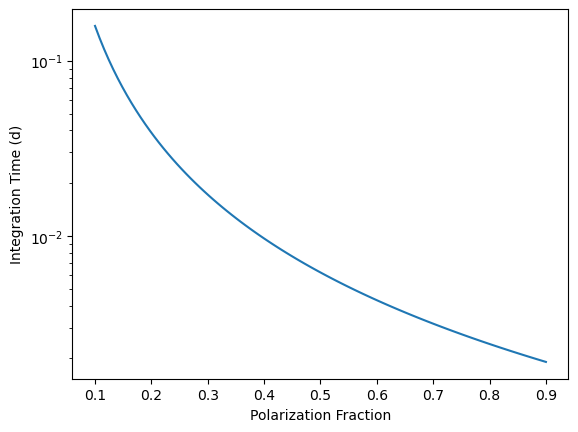

In [8]:
ps = np.linspace(0.1, 0.9, 100)
intTimes = np.zeros(len(ps))*u.d
for j, p in enumerate(ps):
    mode["polfraction"] = p
    intTimes[j] = OS.calc_intTime(TL, sInds, fZ, JEZ, dMag, WA, mode)[0]

plt.figure()
plt.semilogy(ps, intTimes)
plt.xlabel(rf"Polarization Fraction")
plt.ylabel(f"Integration Time ({intTimes.unit})")